In [17]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import time

import optimization
import oracles

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

import oracles
import numpy as np
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, diags
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from inspect import getfullargspec
from itertools import product
from optimization import *
from plot_trajectory_2d import plot_levels, plot_trajectory
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
random.seed(45)
np.random.seed(46)
n_dim = 20
data_num = 10000
A = np.array([np.random.rand(n_dim)*10-5 for _ in range(data_num)])
b = np.array([np.random.rand()*30-15 for _ in range(data_num)])
regcoef = 1.0 / data_num

oracle = oracles.create_log_reg_oracle(A, b, regcoef)

In [19]:
def exp1(c_list, oracle, start_points, method):
    plt.figure(figsize=(16, 9))
    all_res = []
    for c in tqdm(c_list):
        lst = None
        c_type = None
        if method=='Armijo':
            lst = LineSearchTool('Armijo', c1=c)
            c_type = 'c1'
        elif method=='Wolfe':
            lst = LineSearchTool('Wolfe', c1=0.0001, c2=c)
            c_type = 'c2'
        else:
            lst = LineSearchTool('Constant', c=c)
            c_type = 'c'
        history_gds = []
        for start_point in start_points:
            _, _, history_gd = optimization.newton(oracle,start_point,trace=True,line_search_options=lst)
            norm_grad_0 = history_gd['grad_norm'][0]
            norm_grad_0 = norm_grad_0**2
            norm_grad_0 = 1/norm_grad_0
            iters = len(history_gd['time'])
            x = np.arange(iters)
            y = (np.array(history_gd['grad_norm'])**2)*norm_grad_0
            history_gds.append(y)
        max_length = max(len(ele) for ele in history_gds)
        padded_array = np.zeros((len(history_gds), max_length), dtype=int)
        for i, lst in enumerate(history_gds):
            padded_array[i, :len(lst)] = lst
        history_gds = np.array(padded_array)
        history_gds = history_gds.mean(axis=0)
        iters = history_gds.shape[0]
        all_res.append((iters, x, y, c))
    all_res.sort(key = lambda x: x[0])
    plt.figure(figsize=(16, 9))
    for res in all_res[1:]:
        plt.plot(res[1], res[2], label=c_type+' = ' + f'{res[3]:.2f}', linewidth = 2)
    plt.plot(all_res[0][1], all_res[0][2], label=c_type+' = ' + f'{all_res[0][3]:.2f}', linewidth = 4, c='r')
    plt.xlabel('Iterations')
    plt.ylabel('norm_grad2(x)/norm_grad_02')
    plt.legend()
    plt.yscale('log')
    plt.show()

100%|██████████| 8/8 [01:13<00:00,  9.17s/it]


<Figure size 1600x900 with 0 Axes>

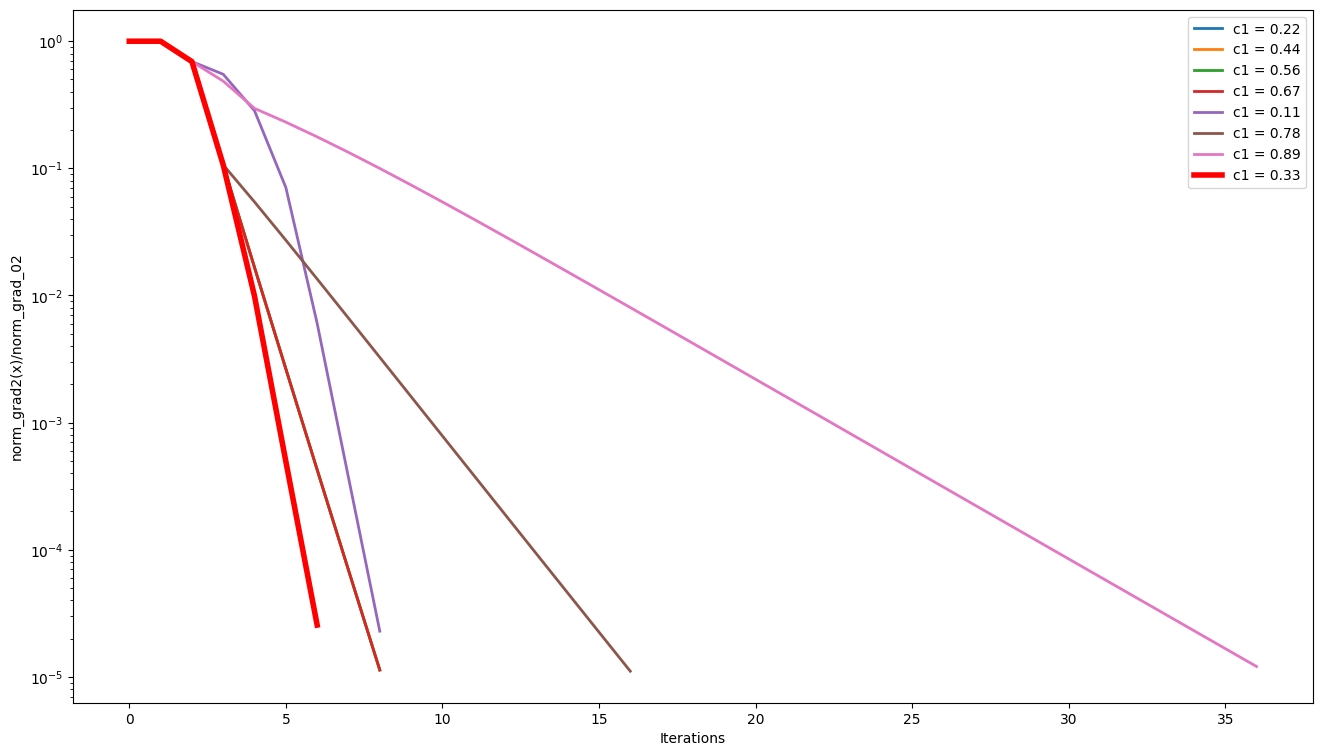

100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


<Figure size 1600x900 with 0 Axes>

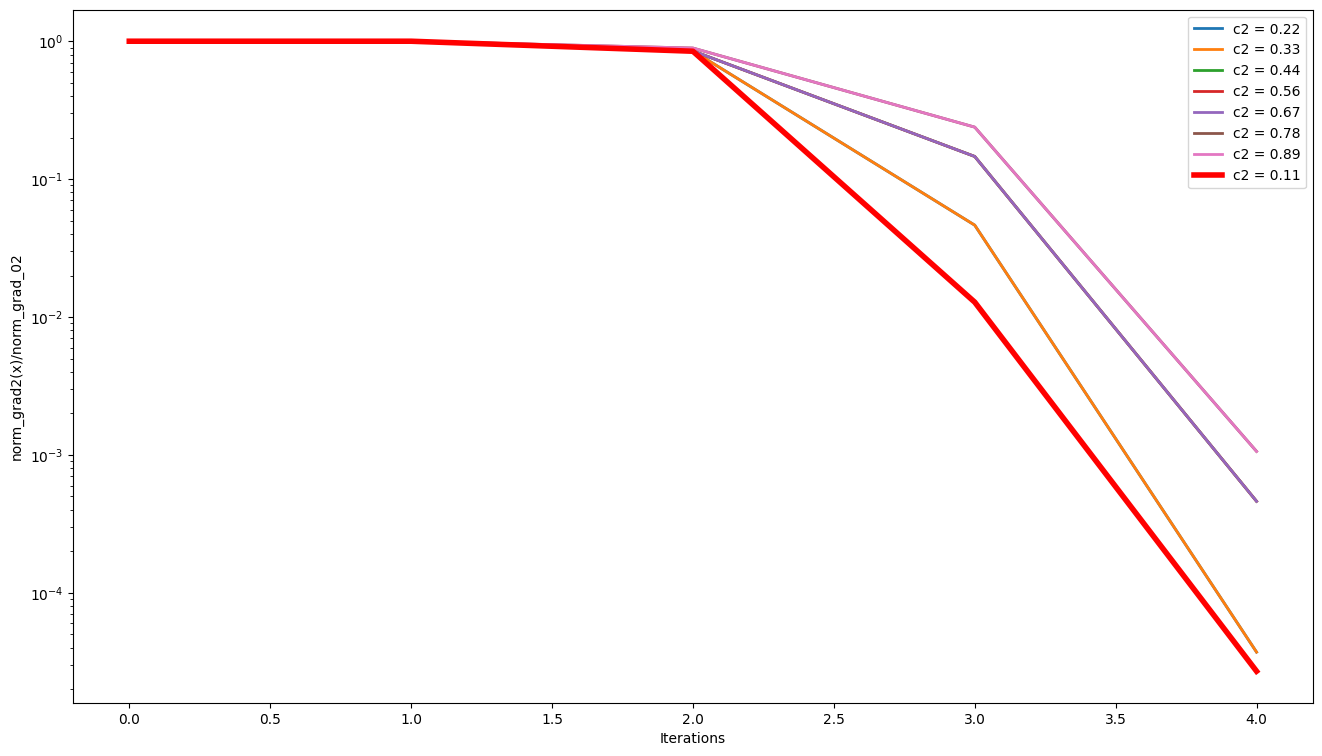

100%|██████████| 8/8 [09:42<00:00, 72.77s/it]


<Figure size 1600x900 with 0 Axes>

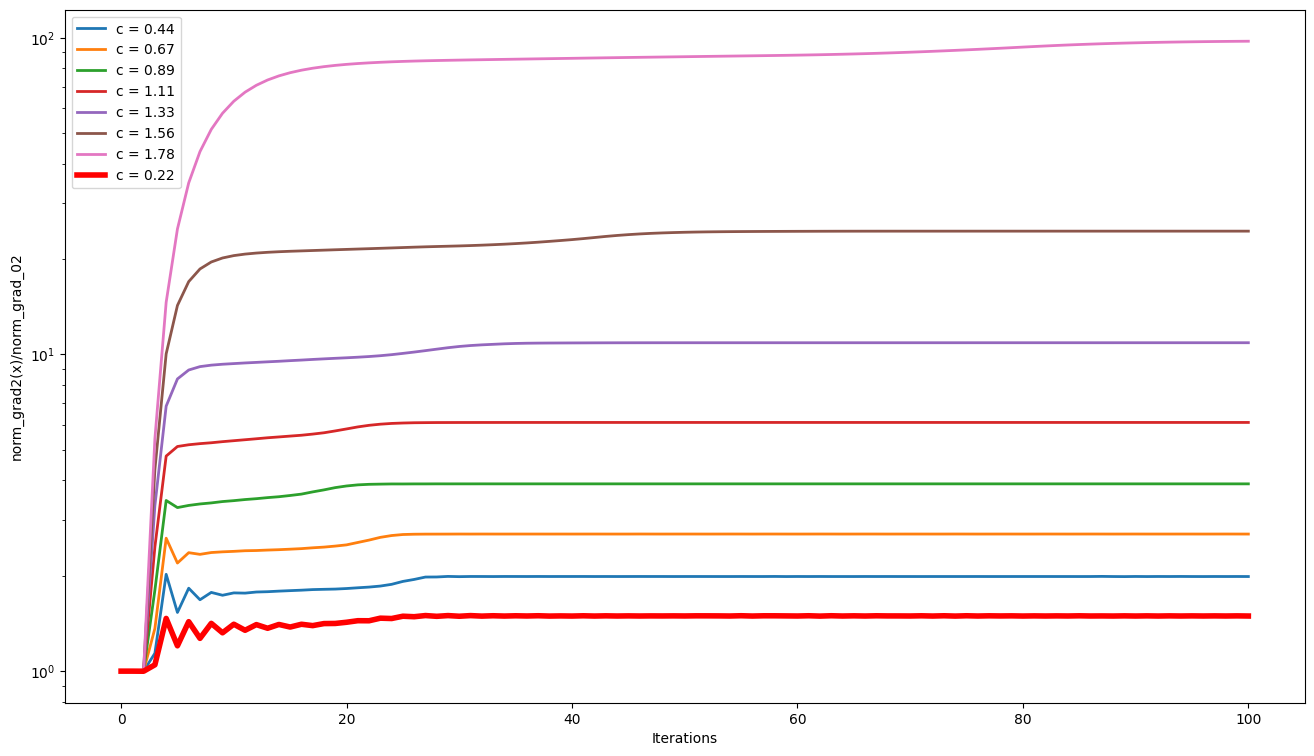

In [20]:
c_list1 = np.linspace(0, 1 ,10)[1:-1]
c_list2 = np.linspace(0.0001, 1 ,10)[1:-1]
c_list3 = np.linspace(0, 2 ,10)[1:-1]
start_points = [np.random.rand(A.shape[1]) for _ in range(4)]
exp1(c_list1, oracle, [np.random.rand(A.shape[1]) for _ in range(5)], 'Armijo')
exp1(c_list2, oracle, [np.random.rand(A.shape[1]) for _ in range(5)], 'Wolfe')
exp1(c_list3, oracle, [np.random.rand(A.shape[1]) for _ in range(5)], 'Constant')

In [21]:
def exp2(c_list, oracle, start_points, method, fxmin):
    plt.figure(figsize=(16, 9))
    all_res = []
    for c in tqdm(c_list):
        lst = None
        c_type = None
        if method=='Armijo':
            lst = LineSearchTool('Armijo', c1=c)
            c_type = 'c1'
        elif method=='Wolfe':
            lst = LineSearchTool('Wolfe', c1=0.0001, c2=c)
            c_type = 'c2'
        else:
            lst = LineSearchTool('Constant', c=c)
            c_type = 'c'
        history_gds = []
        for start_point in start_points:
            _, _, history_gd = optimization.newton(oracle,start_point,trace=True,line_search_options=lst)
            func_x = np.array(history_gd['func'])
            iters = len(history_gd['func'])
            x = np.arange(iters)
            y = (func_x - fxmin)/np.abs(fxmin)
            history_gds.append(y)
        max_length = max(len(ele) for ele in history_gds)
        padded_array = np.zeros((len(history_gds), max_length), dtype=int)
        for i, lst in enumerate(history_gds):
            padded_array[i, :len(lst)] = lst
        history_gds = np.array(padded_array)
        history_gds = history_gds.mean(axis=0)
        iters = history_gds.shape[0]
        all_res.append((iters, x, y, c))
    all_res.sort(key = lambda x: x[0])
    plt.figure(figsize=(16, 9))
    for res in all_res[1:]:
        plt.plot(res[1], res[2], label=c_type+' = ' + f'{res[3]:.2f}', linewidth = 2)
    plt.plot(all_res[0][1], all_res[0][2], label=c_type+' = ' + f'{all_res[0][3]:.2f}', linewidth = 4, c='r')
    plt.xlabel('Iterations')
    plt.ylabel('f(x)-f(x*)/f(x*)')
    plt.legend()
    plt.yscale('log')
    plt.show()

In [22]:
random.seed(45)
np.random.seed(46)
n_dim = 20
diagonal_elements = np.random.rand(n_dim)
A = np.diag(diagonal_elements)
b = np.array([np.random.rand() for _ in range(n_dim)])
A_inv = np.linalg.inv(A)
fxmin = -0.5*b@(A_inv@b)
print(fxmin)
oracle = oracles.QuadraticOracle(A, b)

-6.9661539574310885


100%|██████████| 8/8 [00:00<00:00, 344.61it/s]


<Figure size 1600x900 with 0 Axes>

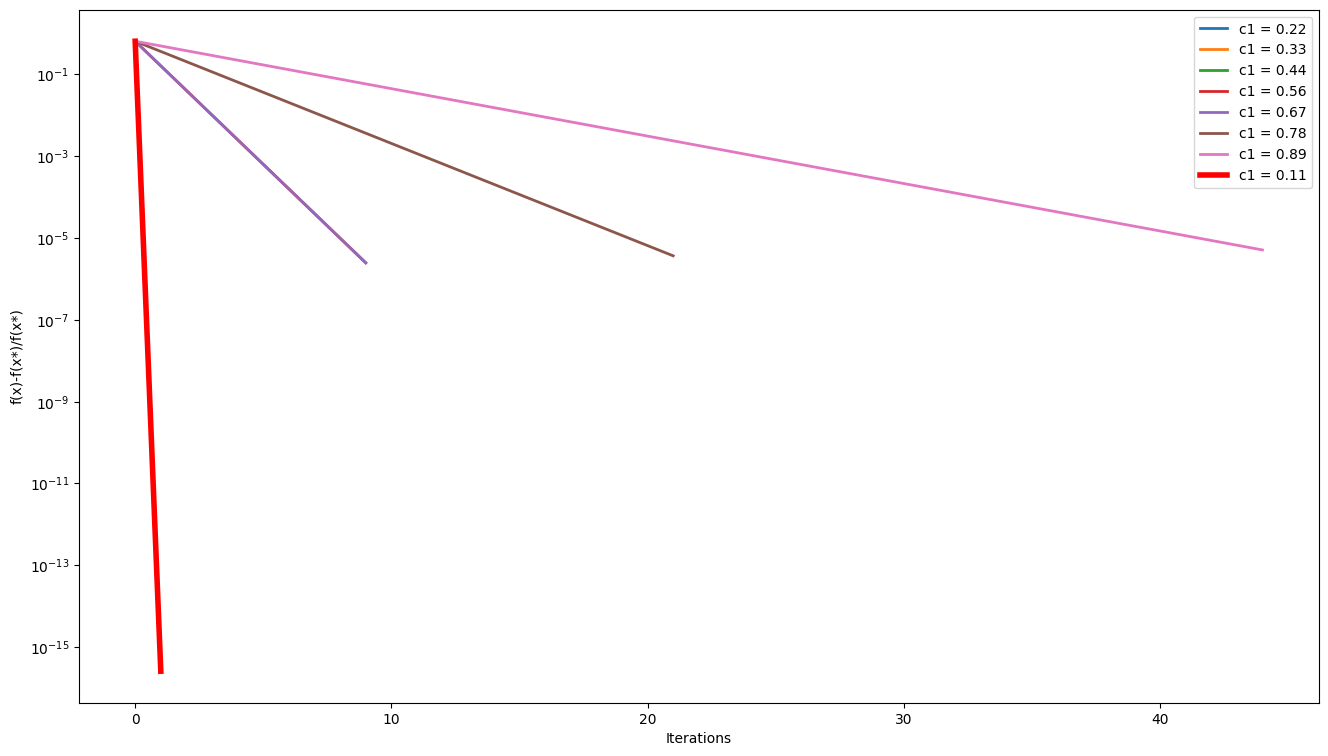

100%|██████████| 8/8 [00:00<00:00, 1918.49it/s]


<Figure size 1600x900 with 0 Axes>

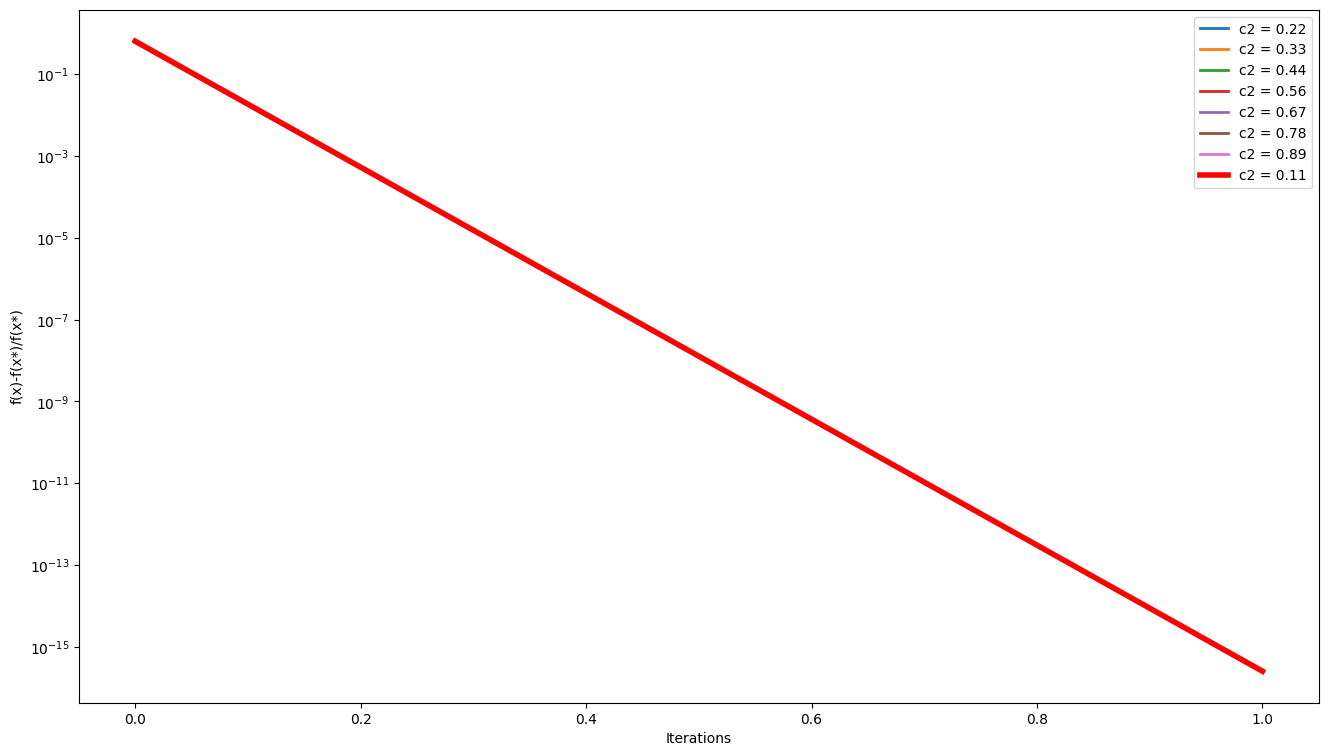

100%|██████████| 8/8 [00:00<00:00, 666.03it/s]


<Figure size 1600x900 with 0 Axes>

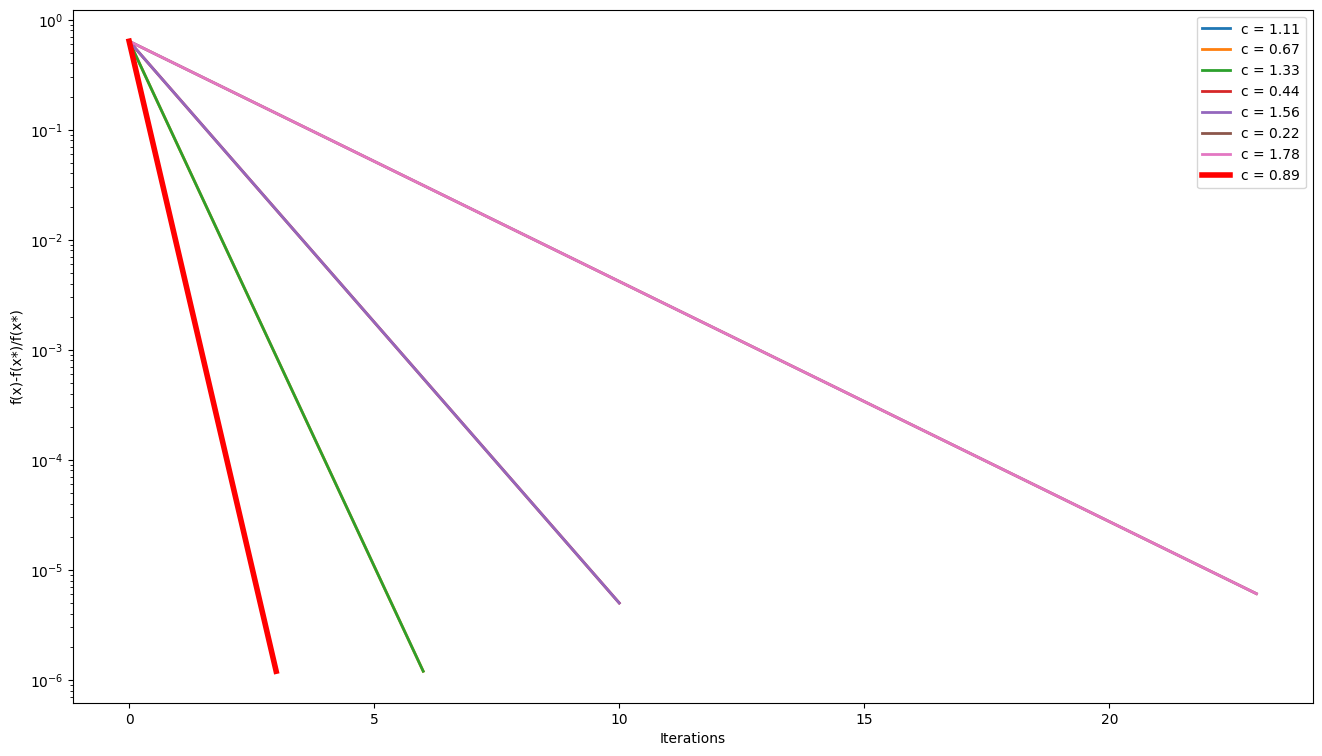

In [23]:
c_list1 = np.linspace(0, 1 ,10)[1:-1]
c_list2 = np.linspace(0.0001, 1 ,10)[1:-1]
c_list3 = np.linspace(0, 2 ,10)[1:-1]
start_points = [np.random.rand(A.shape[1]) for _ in range(4)]
exp2(c_list1, oracle, [np.random.rand(A.shape[1]) for _ in range(5)], 'Armijo', fxmin)
exp2(c_list2, oracle, [np.random.rand(A.shape[1]) for _ in range(5)], 'Wolfe', fxmin)
exp2(c_list3, oracle, [np.random.rand(A.shape[1]) for _ in range(5)], 'Constant', fxmin)